In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR 
import torchvision.transforms.functional as F

import numpy as np
import os
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join('/home/eccoope', 'pv-vision')
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join('/home/eccoope', 'el_img_cracks_ec', 'scripts')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = "/home/nrjost/githome/pvcracks/retrain/"
sys.path.append(ojas_functions_dir)

from tutorials.unet_model import construct_unet
import functions
from torch.utils.data import random_split
import wandb


In [2]:
root = "/home/nrjost/githome/pvcracks_dev/retrain/training/Channeled_Combined_CWRU_LBNL_ASU/"


model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

checkpoint_name = root.split("/")[-2]

In [3]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

In [4]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

def iou_score(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


In [5]:
def load_dataset(root):
    transformers = functions.Compose([functions.ChanneledFixResize(256), functions.ToTensor(), functions.Normalize()])
    
    full_dataset = functions.SolarDataset(
        root, image_folder="img/all", mask_folder="ann/all", transforms=transformers
    )

    return full_dataset

In [6]:
def load_device_and_model(weight_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = torch.device("mps")
    unet = construct_unet(len(category_mapping))
    unet = torch.nn.DataParallel(unet)
    
    model = unet.module.to(device)
    
    return device, model

In [7]:
def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    folders = [folder for folder in os.listdir(checkpoint_dir)]
    
    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)
    
    os.makedirs(new_folder_path, exist_ok=True)
    
    return new_folder_path

In [8]:
full_dataset = load_dataset(root)

In [9]:
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_subset, test_subset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

In [10]:
# this is needed so that we can a) split the dataset into train/test while ensuring our seed is the same as the wandb_k_fold, b) and preserver stuff like __getraw__ from solardataset when doing inference

class SubsetWithRaw(torch.utils.data.Subset):
    def __getraw__(self, idx):
        return self.dataset.__getraw__(self.indices[idx])

train_set = SubsetWithRaw(full_dataset, train_subset.indices)
test_set = SubsetWithRaw(full_dataset, test_subset.indices)

In [11]:
device, model = load_device_and_model(weight_path)

In [12]:
import matplotlib.pyplot as plt

def new_inference_and_show(idx, threshold=0.5):
    # Get the preprocessed image and multi-hot ground truth mask
    img, mask = test_loader.dataset.__getitem__(idx)
    img = img.to(device)
    
    # Get the raw image for display (assuming __getraw__ returns a PIL image)
    raw_img, _ = test_loader.dataset.__getraw__(idx)
    
    # --- Run inference ---
    # Get raw logits from the model, then apply Sigmoid and threshold
    logits = model(img.unsqueeze(0)).detach().cpu()  # shape: [1, 4, H, W]
    probs = torch.sigmoid(logits)                     # shape: [1, 4, H, W]
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # shape: [4, H, W]
    
    # Ground truth is assumed to be already a 4-channel multi-hot mask.
    gt_mask = mask.cpu().numpy()  # shape: [4, H, W]
    
    # --- Visualization ---
    # Create a grid with 3 rows and 4 columns:
    #   Row 0: Raw image (displayed only once in the first column)
    #   Row 1: Ground truth masks for each class
    #   Row 2: Predicted masks for each class
    n_classes = len(category_mapping)
    class_names = [f'({k}) {v}' for k, v in category_mapping.items()]
    
    fig, axs = plt.subplots(3, n_classes, figsize=(4*n_classes, 12))
    
    # Row 0: Display raw image in first subplot; hide other subplots in this row.
    axs[0, 0].imshow(raw_img.convert('L'), cmap='viridis')
    axs[0, 0].set_title("Raw Image")
    axs[0, 0].axis('off')
    for j in range(1, n_classes):
        axs[0, j].axis('off')
    
    # Row 1: Ground truth for each class (each channel)
    for j in range(n_classes):
        axs[1, j].imshow(gt_mask[j], cmap='viridis')
        axs[1, j].set_title(f"GT: {class_names[j]}")
        axs[1, j].axis('off')
    
    # Row 2: Predictions for each class (each channel)
    for j in range(n_classes):
        axs[2, j].imshow(pred_mask[j], cmap='viridis')
        axs[2, j].set_title(f"Pred: {class_names[j]}")
        axs[2, j].axis('off')
    
    fig.suptitle("Retrained Model Prediction", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Training

In [13]:
save_name = "model.pt"
save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

original_config = {
    "batch_size_train": 32,
    "lr": 0.00092234,#wandb run: playful-shape-234 #0.00092234,
    "gamma": 0.11727,#wandb #0.11727,
    "num_epochs": 45,#wandb
    
    # constants
    "batch_size_test": 32, #check VAE 
    "criterion": torch.nn.BCEWithLogitsLoss(),
    "k_folds": 5,
    # "lr_scheduler_step_size": 1,
}

config_serializable = original_config.copy()
config_serializable["criterion"] = str(config_serializable["criterion"])

with open(os.path.join(save_dir, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config_serializable, f, ensure_ascii=False, indent=4)

run = wandb.init(
    project="pvcracks",
    entity="ojas-sanghi-university-of-arizona",
    config=original_config,
)
config = wandb.config

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ojas-sanghi (ojas-sanghi-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
train_loader = DataLoader(train_set, batch_size=config.batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=config.batch_size_test, shuffle=False)

In [15]:
optimizer = Adam(model.parameters(), lr=config.lr)

# log gradients
run.watch(model, log_freq=100)

In [16]:
training_epoch_loss = []
test_epoch_loss = []
test_dice_loss = []
test_iou_loss = []

best_epoch_test_loss = float("inf")
best_epoch_dice = 0.0
best_epoch_iou = 0.0

for epoch in tqdm(range(1, config.num_epochs + 1)):
    
    training_step_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calc loss -- bce with logits loss applies sigmoid interally
        training_loss = original_config["criterion"](output, target)
        #backward pass
        training_loss.backward()
        optimizer.step()
        # record loss
        training_step_loss.append(training_loss.item())
        
    test_step_loss = []
    dice_scores = []
    iou_scores = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = target.float()
        # forward pass
        # data = data.to(device)
        output = model(data)
        
        # calc loss -- bce with logits loss applies sigmoid interally
        test_loss = original_config["criterion"](output, target)
        test_step_loss.append(test_loss.item())
        
        # compute dice and iou
        pred_probs = torch.sigmoid(output)
        pred_binary = (pred_probs > 0.5).float()
        for i in range(pred_binary.size(1)):
            dice = dice_coefficient(pred_binary[:, i], target[:, i])
            iou = iou_score(pred_binary[:, i], target[:, i])
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
        
    epoch_train_loss = np.mean(training_step_loss)
    epoch_test_loss = np.mean(test_step_loss)
    epoch_avg_dice = np.mean(dice_scores)
    epoch_avg_iou = np.mean(iou_scores)
    
    training_epoch_loss.append(epoch_train_loss)
    test_epoch_loss.append(epoch_test_loss)
    test_dice_loss.append(epoch_avg_dice)
    test_iou_loss.append(epoch_avg_iou)
    
    run.log({
        "train_loss": epoch_train_loss,
        "test_loss": epoch_test_loss,
        "avg_dice": epoch_avg_dice,
        "avg_iou": epoch_avg_iou,
    }, step=epoch)
    
    
    if epoch_test_loss < best_epoch_test_loss:
        best_epoch_test_loss = epoch_test_loss
        best_epoch_dice = epoch_avg_dice
        best_epoch_iou = epoch_avg_iou
        
        os.makedirs(os.path.join(save_dir, f'epoch_{epoch}'), exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch}', save_name))
        print(f'Saved model at epoch {epoch}')

    print(f"Epoch {epoch} best test_loss: {best_epoch_test_loss:.4f}, dice: {best_epoch_dice:.4f}, iou: {best_epoch_iou:.4f}")

  2%|▏         | 1/45 [02:14<1:38:31, 134.35s/it]

Saved model at epoch 1
Epoch 1 best test_loss: 0.1453, dice: 0.6282, iou: 0.5457


  4%|▍         | 2/45 [02:46<53:15, 74.32s/it]   

Saved model at epoch 2
Epoch 2 best test_loss: 0.0786, dice: 0.6400, iou: 0.5617


  7%|▋         | 3/45 [03:18<38:32, 55.05s/it]

Saved model at epoch 3
Epoch 3 best test_loss: 0.0568, dice: 0.7991, iou: 0.6847


  9%|▉         | 4/45 [03:51<31:30, 46.10s/it]

Saved model at epoch 4
Epoch 4 best test_loss: 0.0490, dice: 0.7969, iou: 0.6848


 11%|█         | 5/45 [04:22<27:18, 40.95s/it]

Saved model at epoch 5
Epoch 5 best test_loss: 0.0441, dice: 0.8497, iou: 0.7451


 13%|█▎        | 6/45 [04:55<24:43, 38.03s/it]

Saved model at epoch 6
Epoch 6 best test_loss: 0.0413, dice: 0.8455, iou: 0.7393


 16%|█▌        | 7/45 [05:27<22:56, 36.22s/it]

Saved model at epoch 7
Epoch 7 best test_loss: 0.0382, dice: 0.8655, iou: 0.7673


 18%|█▊        | 8/45 [06:00<21:32, 34.94s/it]

Saved model at epoch 8
Epoch 8 best test_loss: 0.0365, dice: 0.8640, iou: 0.7655


 20%|██        | 9/45 [06:32<20:24, 34.02s/it]

Saved model at epoch 9
Epoch 9 best test_loss: 0.0363, dice: 0.8640, iou: 0.7660


 22%|██▏       | 10/45 [07:04<19:33, 33.53s/it]

Saved model at epoch 10
Epoch 10 best test_loss: 0.0353, dice: 0.8725, iou: 0.7777


 24%|██▍       | 11/45 [07:36<18:49, 33.21s/it]

Saved model at epoch 11
Epoch 11 best test_loss: 0.0346, dice: 0.8682, iou: 0.7719


 27%|██▋       | 12/45 [08:09<18:09, 33.00s/it]

Saved model at epoch 12
Epoch 12 best test_loss: 0.0334, dice: 0.8798, iou: 0.7889


 29%|██▉       | 13/45 [08:41<17:22, 32.58s/it]

Epoch 13 best test_loss: 0.0334, dice: 0.8798, iou: 0.7889


 31%|███       | 14/45 [09:13<16:45, 32.43s/it]

Saved model at epoch 14
Epoch 14 best test_loss: 0.0324, dice: 0.8843, iou: 0.7963


 33%|███▎      | 15/45 [09:44<16:05, 32.17s/it]

Epoch 15 best test_loss: 0.0324, dice: 0.8843, iou: 0.7963


 36%|███▌      | 16/45 [10:16<15:28, 32.00s/it]

Epoch 16 best test_loss: 0.0324, dice: 0.8843, iou: 0.7963


 38%|███▊      | 17/45 [10:48<14:56, 32.03s/it]

Saved model at epoch 17
Epoch 17 best test_loss: 0.0323, dice: 0.8850, iou: 0.7971


 40%|████      | 18/45 [11:20<14:21, 31.90s/it]

Epoch 18 best test_loss: 0.0323, dice: 0.8850, iou: 0.7971


 42%|████▏     | 19/45 [11:52<13:50, 31.96s/it]

Saved model at epoch 19
Epoch 19 best test_loss: 0.0317, dice: 0.8829, iou: 0.7937


 44%|████▍     | 20/45 [12:23<13:15, 31.84s/it]

Epoch 20 best test_loss: 0.0317, dice: 0.8829, iou: 0.7937


 47%|████▋     | 21/45 [12:55<12:45, 31.91s/it]

Saved model at epoch 21
Epoch 21 best test_loss: 0.0308, dice: 0.8891, iou: 0.8038


 49%|████▉     | 22/45 [13:27<12:13, 31.88s/it]

Epoch 22 best test_loss: 0.0308, dice: 0.8891, iou: 0.8038


 51%|█████     | 23/45 [13:59<11:39, 31.78s/it]

Epoch 23 best test_loss: 0.0308, dice: 0.8891, iou: 0.8038


 53%|█████▎    | 24/45 [14:30<11:05, 31.69s/it]

Epoch 24 best test_loss: 0.0308, dice: 0.8891, iou: 0.8038


 56%|█████▌    | 25/45 [15:02<10:32, 31.65s/it]

Epoch 25 best test_loss: 0.0308, dice: 0.8891, iou: 0.8038


 58%|█████▊    | 26/45 [15:34<10:03, 31.79s/it]

Saved model at epoch 26
Epoch 26 best test_loss: 0.0307, dice: 0.8867, iou: 0.8008


 60%|██████    | 27/45 [16:05<09:30, 31.71s/it]

Epoch 27 best test_loss: 0.0307, dice: 0.8867, iou: 0.8008


 62%|██████▏   | 28/45 [16:37<08:58, 31.66s/it]

Epoch 28 best test_loss: 0.0307, dice: 0.8867, iou: 0.8008


 64%|██████▍   | 29/45 [17:08<08:25, 31.62s/it]

Epoch 29 best test_loss: 0.0307, dice: 0.8867, iou: 0.8008


 67%|██████▋   | 30/45 [17:40<07:53, 31.56s/it]

Epoch 30 best test_loss: 0.0307, dice: 0.8867, iou: 0.8008


 69%|██████▉   | 31/45 [18:12<07:23, 31.66s/it]

Saved model at epoch 31
Epoch 31 best test_loss: 0.0307, dice: 0.8855, iou: 0.7980


 71%|███████   | 32/45 [18:44<06:52, 31.76s/it]

Saved model at epoch 32
Epoch 32 best test_loss: 0.0300, dice: 0.8904, iou: 0.8058


 73%|███████▎  | 33/45 [19:15<06:20, 31.67s/it]

Epoch 33 best test_loss: 0.0300, dice: 0.8904, iou: 0.8058


 76%|███████▌  | 34/45 [19:47<05:47, 31.62s/it]

Epoch 34 best test_loss: 0.0300, dice: 0.8904, iou: 0.8058


 78%|███████▊  | 35/45 [20:20<05:21, 32.17s/it]

Saved model at epoch 35
Epoch 35 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 80%|████████  | 36/45 [20:52<04:48, 32.00s/it]

Epoch 36 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 82%|████████▏ | 37/45 [21:23<04:15, 31.88s/it]

Epoch 37 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 84%|████████▍ | 38/45 [21:55<03:42, 31.77s/it]

Epoch 38 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 87%|████████▋ | 39/45 [22:26<03:10, 31.68s/it]

Epoch 39 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 89%|████████▉ | 40/45 [22:58<02:38, 31.65s/it]

Epoch 40 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 91%|█████████ | 41/45 [23:29<02:06, 31.61s/it]

Epoch 41 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 93%|█████████▎| 42/45 [24:01<01:34, 31.58s/it]

Epoch 42 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 96%|█████████▌| 43/45 [24:32<01:03, 31.58s/it]

Epoch 43 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


 98%|█████████▊| 44/45 [25:04<00:31, 31.60s/it]

Epoch 44 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


100%|██████████| 45/45 [25:36<00:00, 34.14s/it]

Epoch 45 best test_loss: 0.0293, dice: 0.8941, iou: 0.8119


In [17]:
run.finish()

avg_dice,▁▁▅▅▇▇▇▇▇▇█▇██▇█████████████████████████
avg_iou,▁▁▅▅▆▆▇▇▇▇▇▇█▇▇██▇███▇████▇█████████████
test_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_dice,0.89408
avg_iou,0.81177
test_loss,0.03002
train_loss,0.02248


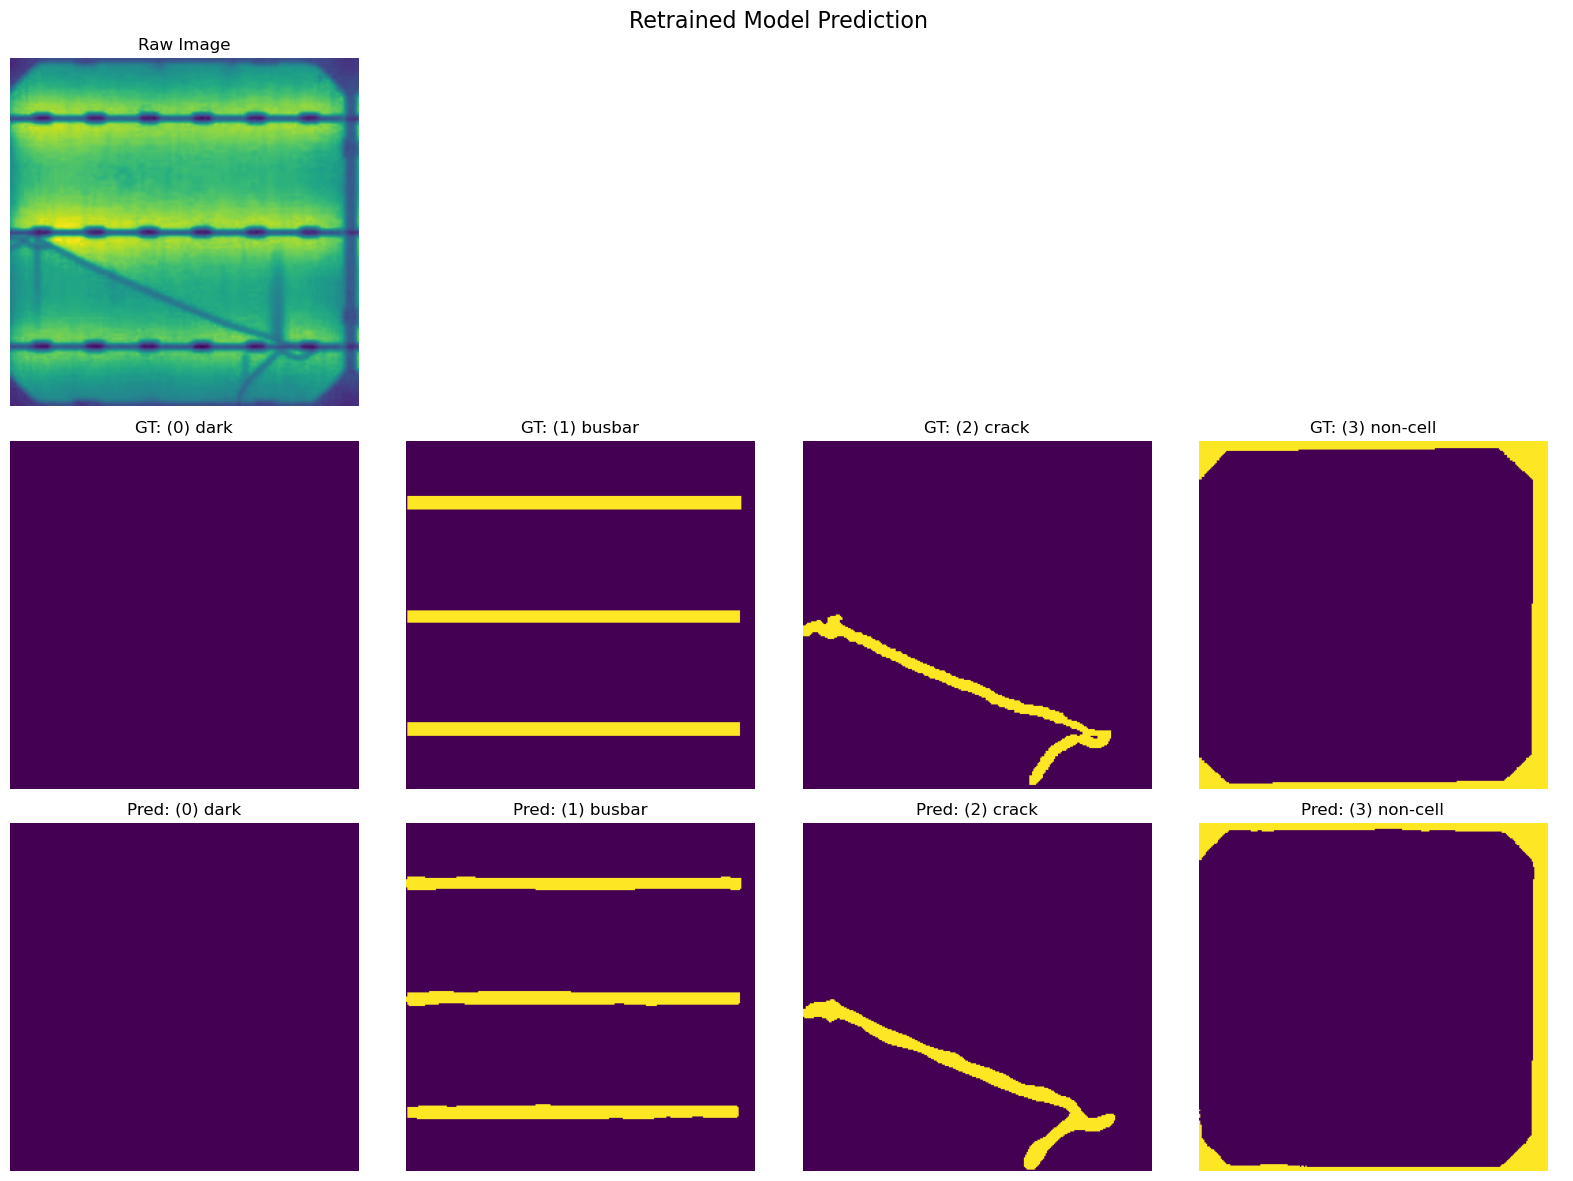

In [18]:
new_inference_and_show(-32)

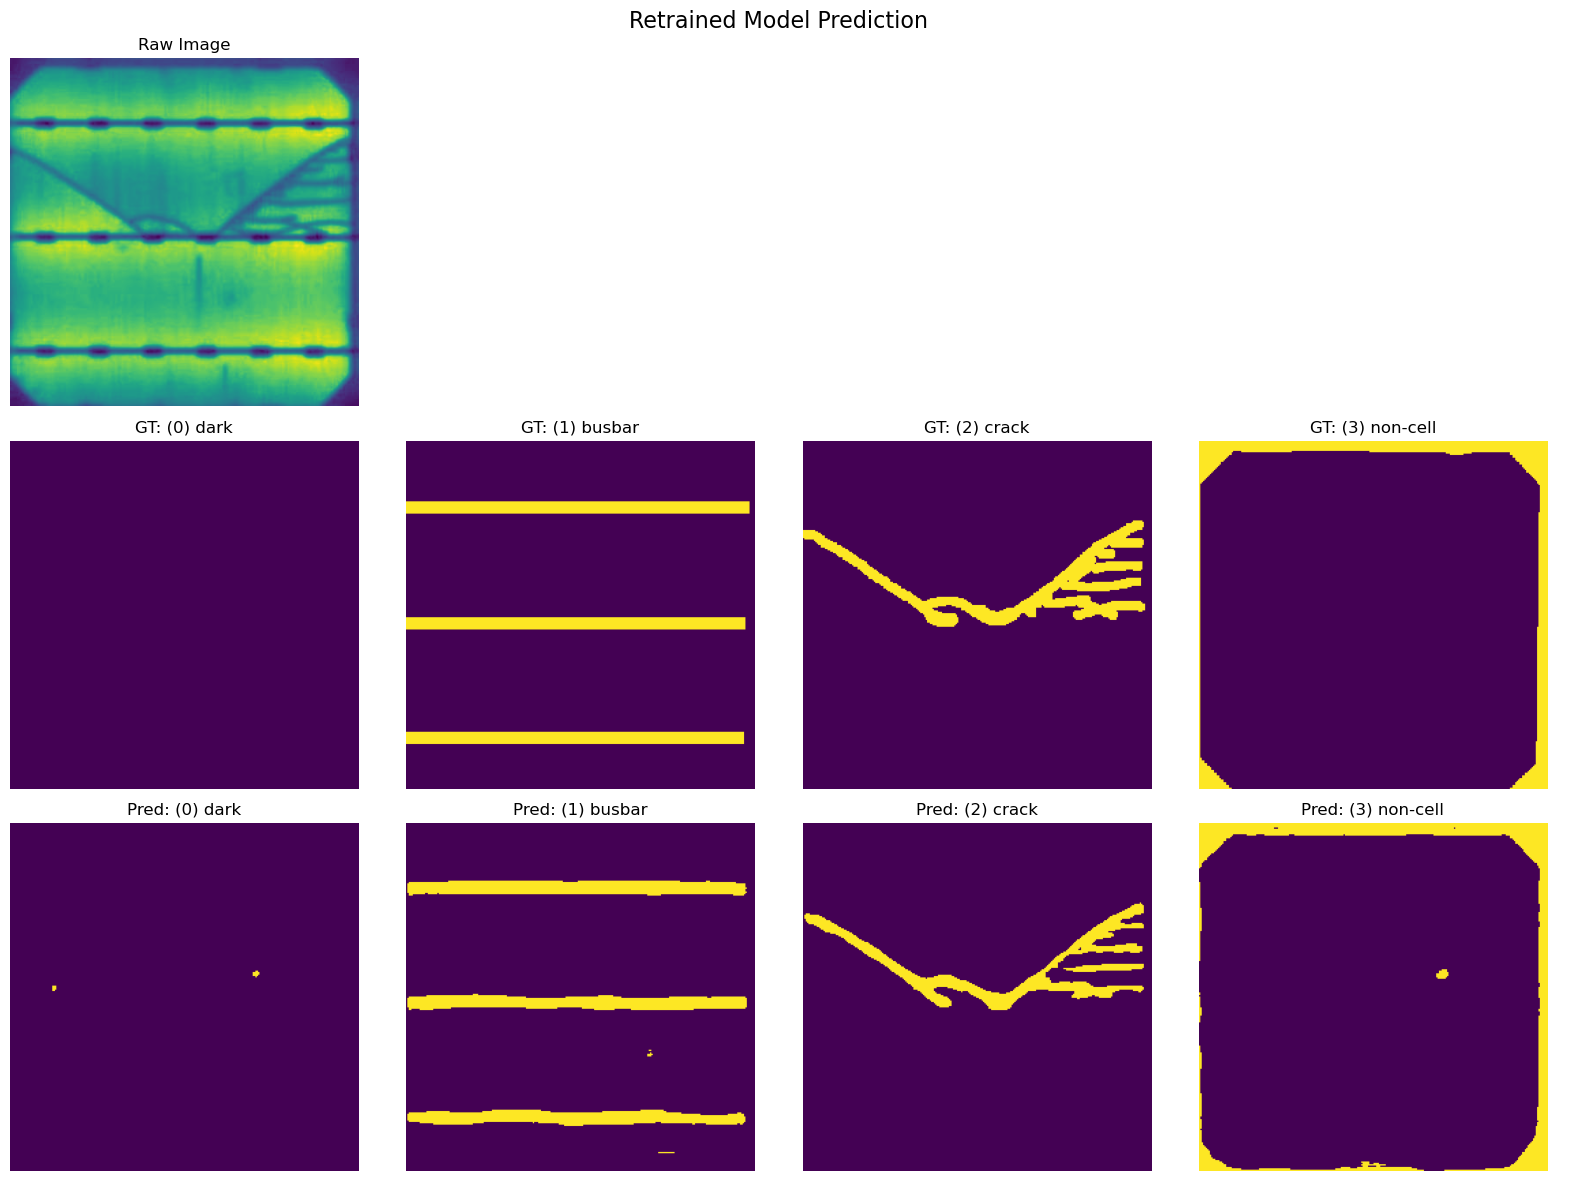

In [19]:
new_inference_and_show(13)

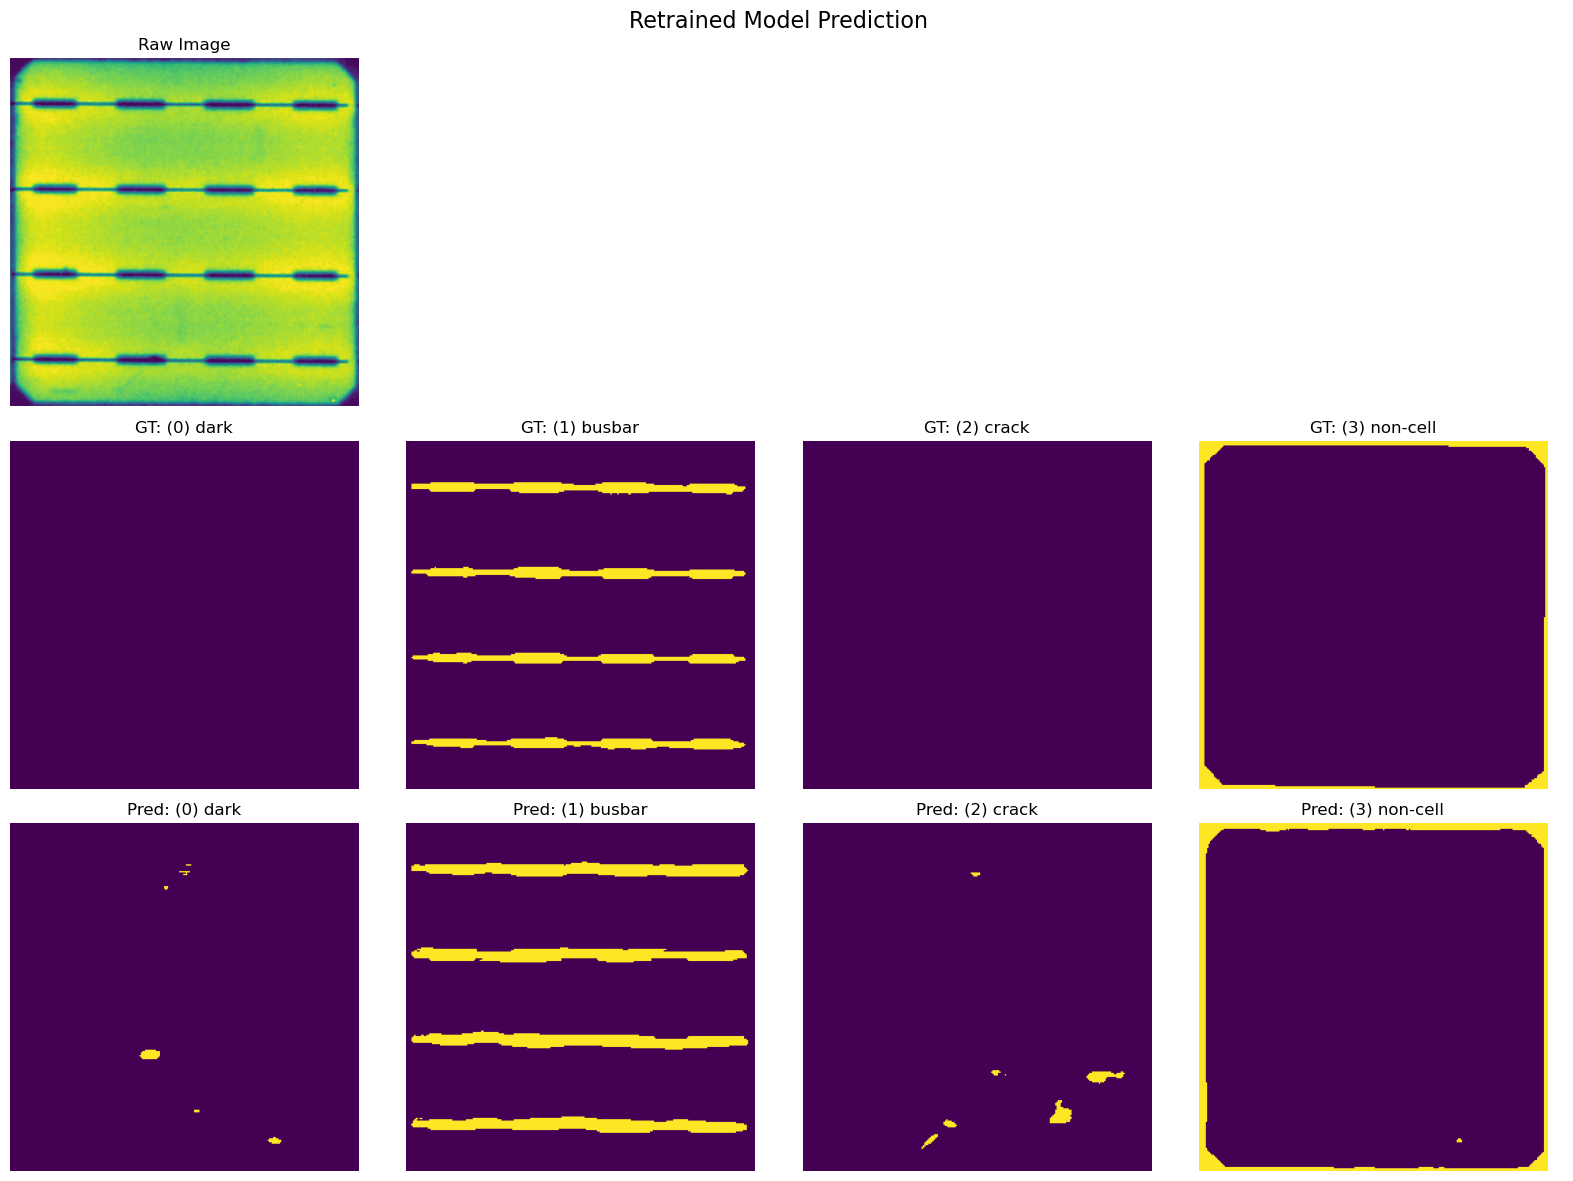

In [20]:
new_inference_and_show(44)

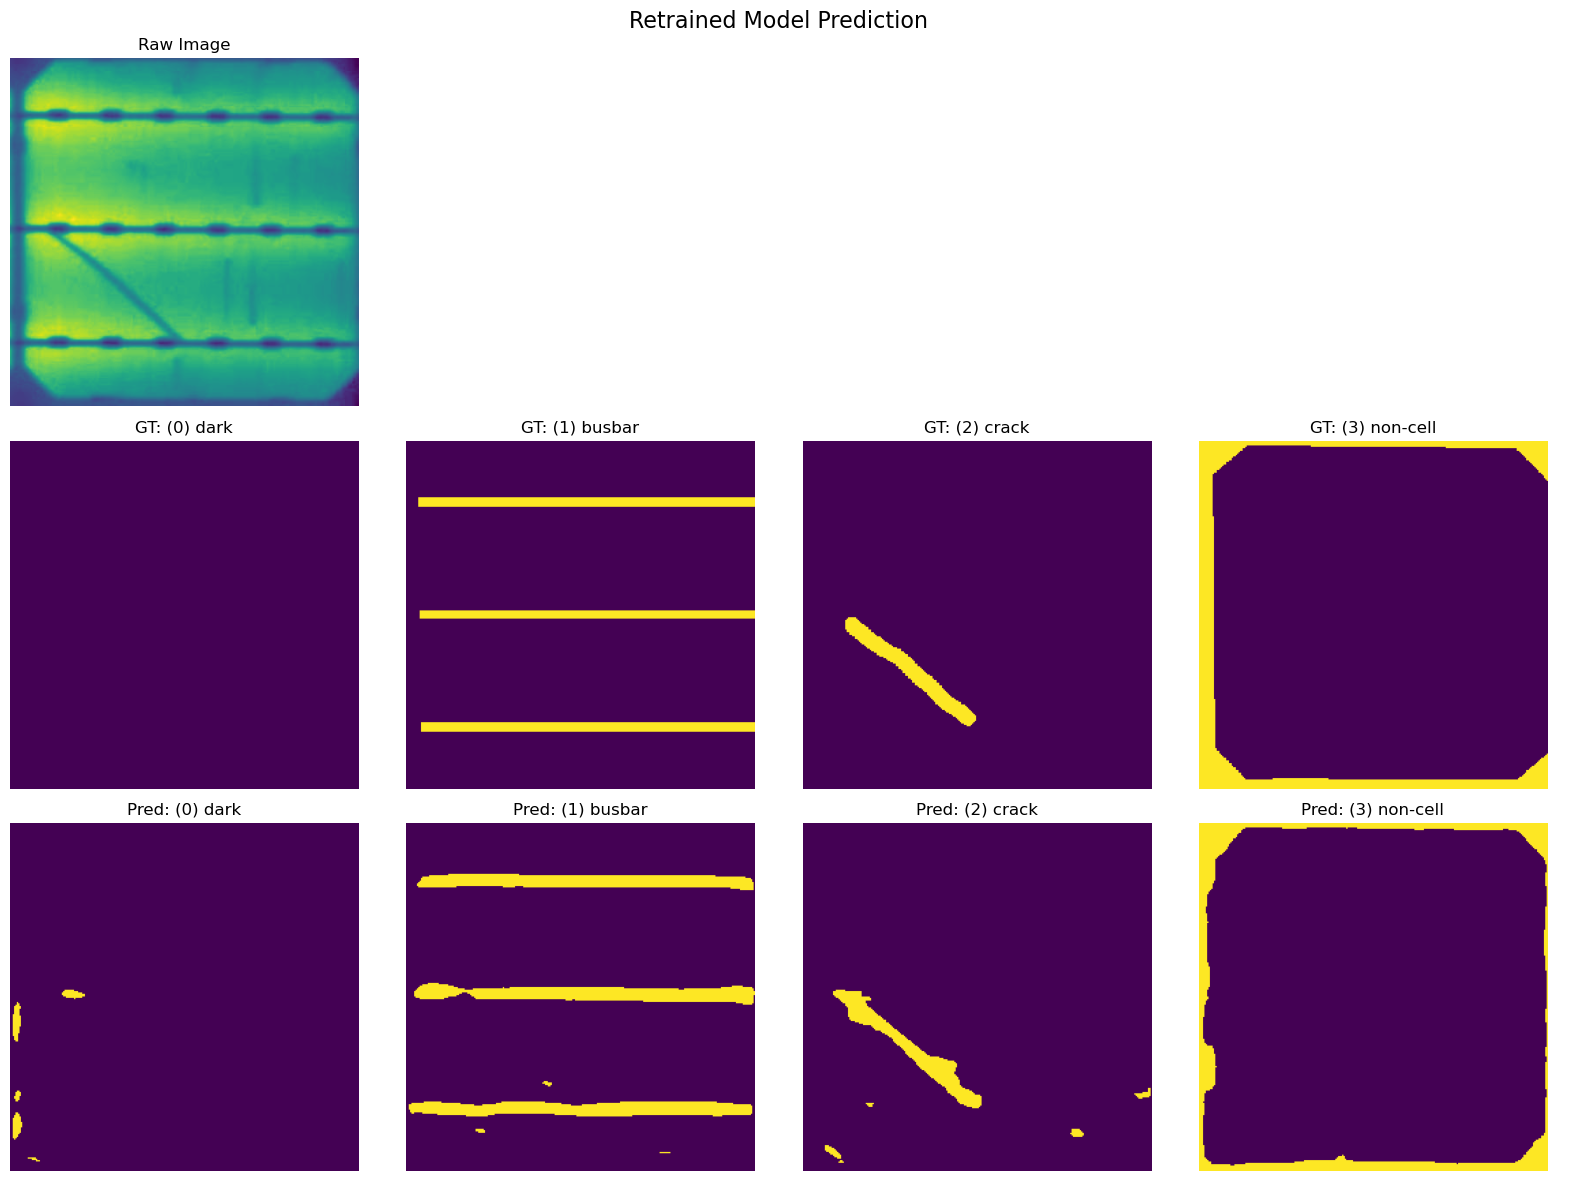

In [21]:
new_inference_and_show(1)

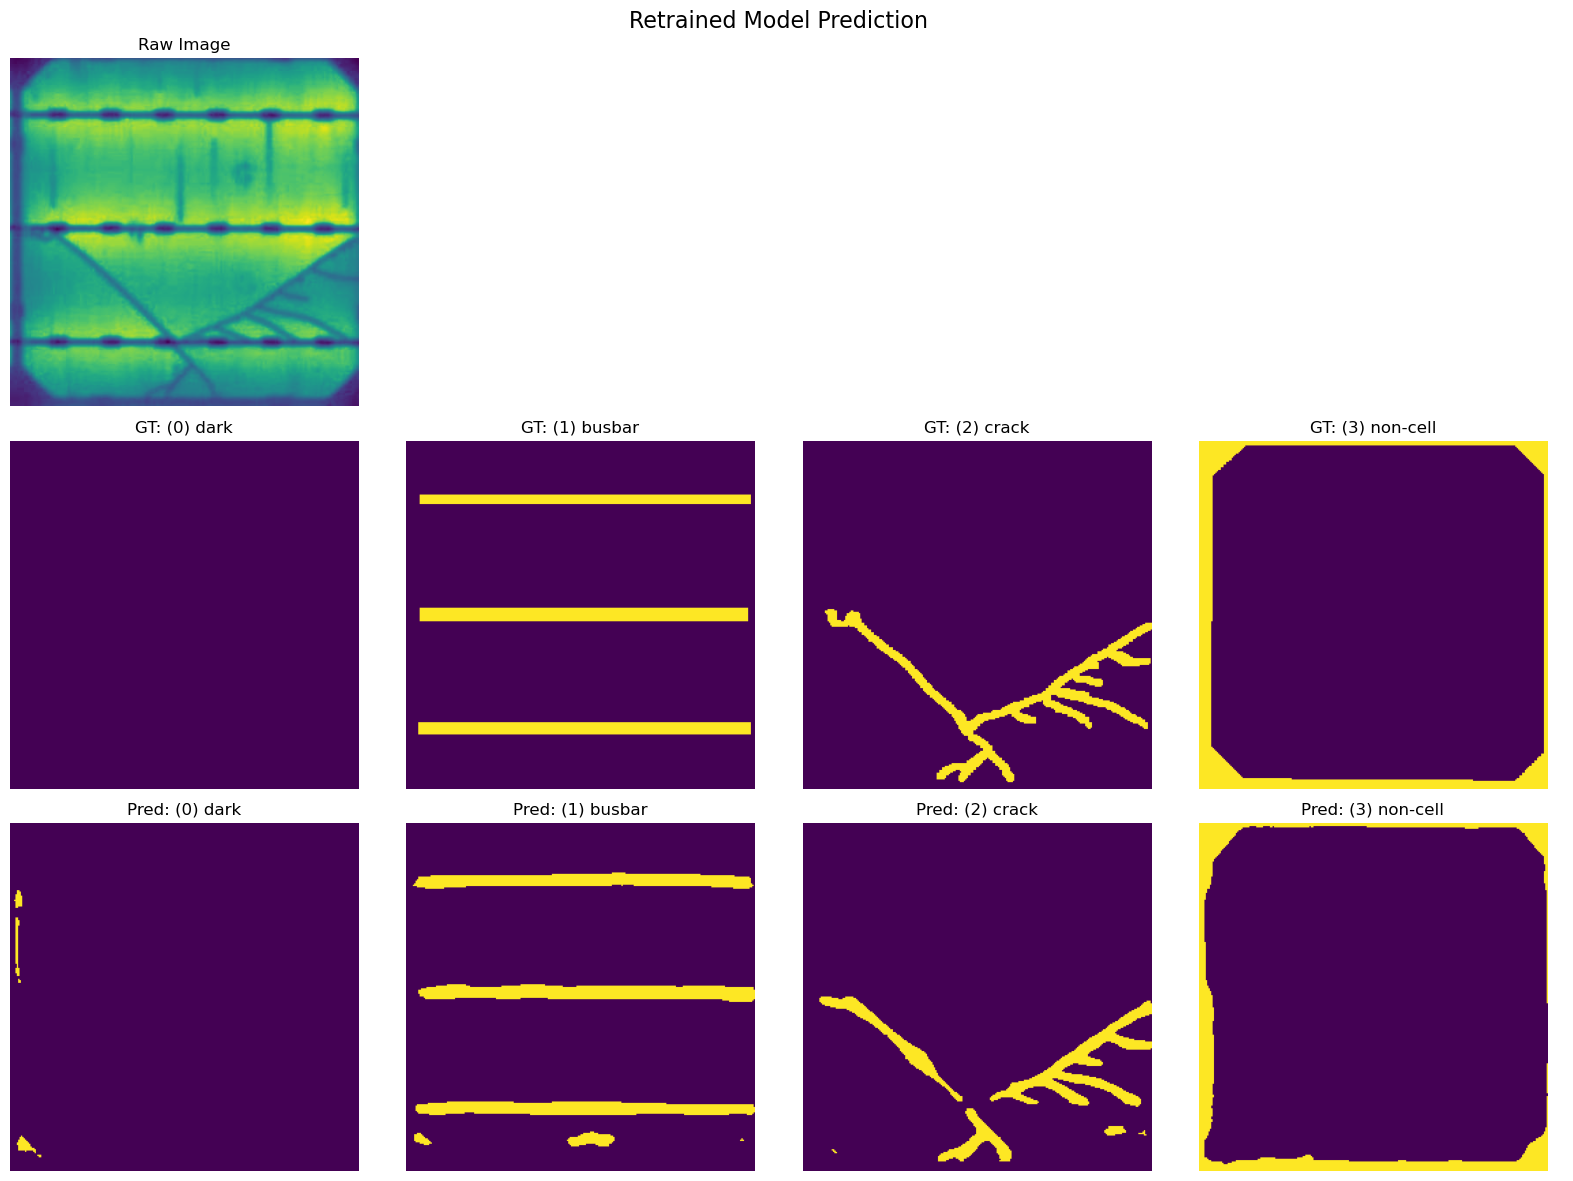

In [22]:
new_inference_and_show(6)

In [23]:
# for i in range(100):
#     new_inference_and_show(i)

[np.float64(0.2755444160465038), np.float64(0.09983891824429686), np.float64(0.06259526696169015), np.float64(0.04941763672413248), np.float64(0.04312887229025364), np.float64(0.039843721597483665), np.float64(0.03743736807144049), np.float64(0.03522455957577084), np.float64(0.0343201845658548), np.float64(0.03330600814837398), np.float64(0.032838930347652145), np.float64(0.03179416046336745), np.float64(0.03197804234470382), np.float64(0.031063448101507896), np.float64(0.030652339146895843), np.float64(0.03033963181642872), np.float64(0.029866529910853416), np.float64(0.03142347183981628), np.float64(0.031153942542997273), np.float64(0.029413673434067856), np.float64(0.029183670172862934), np.float64(0.02889097800873446), np.float64(0.02833009601542444), np.float64(0.028067405787155483), np.float64(0.027911857730059914), np.float64(0.028059264080542507), np.float64(0.027568721833328407), np.float64(0.027374473908408123), np.float64(0.02745376764373346), np.float64(0.02724456250893347)

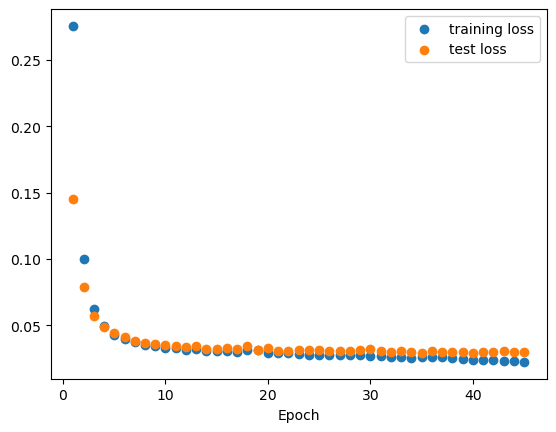

In [24]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label='training loss')
ax.scatter(x, test_epoch_loss, label='test loss')
ax.legend()
ax.set_xlabel('Epoch')

print(training_epoch_loss)


In [25]:
test_epoch_loss

[np.float64(0.14531591907143593),
 np.float64(0.07859961315989494),
 np.float64(0.056777306366711855),
 np.float64(0.04902364453300834),
 np.float64(0.04408386489376426),
 np.float64(0.0413311212323606),
 np.float64(0.03822811786085367),
 np.float64(0.036480142967775464),
 np.float64(0.03626046376302838),
 np.float64(0.03527402272447944),
 np.float64(0.03462111670523882),
 np.float64(0.033412596210837364),
 np.float64(0.03436622628942132),
 np.float64(0.0323506654240191),
 np.float64(0.03242815285921097),
 np.float64(0.03269512252882123),
 np.float64(0.03229064121842384),
 np.float64(0.034680204931646585),
 np.float64(0.0317488550208509),
 np.float64(0.03264473401941359),
 np.float64(0.030765883391723037),
 np.float64(0.03091206564567983),
 np.float64(0.03133492264896631),
 np.float64(0.0313800391741097),
 np.float64(0.031454599695280194),
 np.float64(0.030735677806660533),
 np.float64(0.03091924055479467),
 np.float64(0.03098551486618817),
 np.float64(0.031528346007689834),
 np.float6